In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# GPU設定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# データのダウンロード

In [3]:
# ダウンロード
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

In [6]:
# 入力画像の次元拡張
x_train = x_train[:, :, :, np.newaxis]
x_train.shape

(60000, 28, 28, 1)

In [7]:
# One-hot
(y_train, y_test) = (np_utils.to_categorical(y_train), np_utils.to_categorical(y_test))
y_train.shape

(60000, 10)

Text(0.5, 1.0, '7')

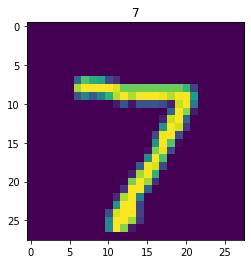

In [8]:
# テスト画像の表示
i = 0
label = y_test[i].argmax()
plt.imshow(x_test[i])
plt.title(label)

# モデル作成

In [9]:
from keras.layers import Input, ZeroPadding2D, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from keras import Model

In [10]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu')(inputs)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', name='feature_map')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax', name='dense')(x)

In [11]:
model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
feature_map (Conv2D)         (None, 14, 14, 128)       73856     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290

In [14]:
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 8s 152us/step - loss: 0.4905 - accuracy: 0.8460 - val_loss: 0.0729 - val_accuracy: 0.9792
Epoch 2/5
54000/54000 [==============================] - 7s 129us/step - loss: 0.1336 - accuracy: 0.9610 - val_loss: 0.0426 - val_accuracy: 0.9885
Epoch 3/5
54000/54000 [==============================] - 7s 121us/step - loss: 0.0988 - accuracy: 0.9711 - val_loss: 0.0389 - val_accuracy: 0.9888
Epoch 4/5
54000/54000 [==============================] - 7s 132us/step - loss: 0.0829 - accuracy: 0.9762 - val_loss: 0.0353 - val_accuracy: 0.9907
Epoch 5/5
54000/54000 [==============================] - 7s 129us/step - loss: 0.0704 - accuracy: 0.9786 - val_loss: 0.0347 - val_accuracy: 0.9913


# 結果

Text(0.5, 1.0, 'pred=4, ans=4')

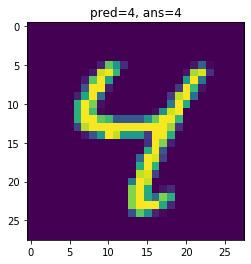

In [15]:
# テスト画像の表示
i = np.random.randint(0, 11)
pred = model.predict(x_test[i][np.newaxis, :, :, np.newaxis]).argmax()
ans = y_test[i].argmax()

plt.imshow(x_test[i])
plt.title('pred={0}, ans={1}'.format(pred, ans))

# CAM

In [16]:
# modelのレイヤーを辞書にする
layer_dic = {l.name: l for l in model.layers}

In [17]:
# 中間層を出力するモデルを作成する
cam_model = Model(inputs=model.input, outputs=layer_dic['feature_map'].output)
cam_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
feature_map (Conv2D)         (None, 14, 14, 128)       73856     
Total params: 93,184
Trainable params: 93,184
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 全結合層の重み、バイアスを取得する
w, b = layer_dic['dense'].get_weights()

### 可視化

In [21]:
# 全テスト画像の特徴マップを取り出す
feature_map = cam_model.predict(x_test[:, :, :, np.newaxis])
feature_map.shape

(10000, 14, 14, 128)

In [110]:
# Class Activation Map 作成
cam = feature_map.dot(w) + b
# 画像ごとに標準化しておく
#import scipy.stats
#cam = scipy.stats.zscore(cam, axis=0)
cam.shape

(10000, 14, 14, 10)

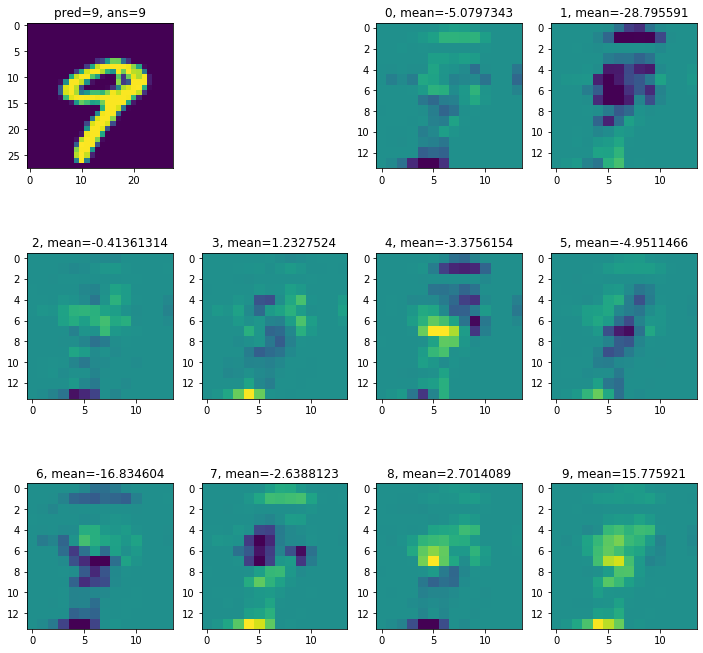

In [114]:
# あるテスト画像のCAM表示
i = np.random.randint(0, 11)

pred = model.predict(x_test[i][np.newaxis, :, :, np.newaxis]).argmax()
ans = y_test[i].argmax()

plt.figure(figsize=(12, 12))
plt.subplot(341)
plt.imshow(x_test[i])
plt.title('pred={0}, ans={1}'.format(pred, ans))
for j in range(10):
    cam_class = cam[i, :, :, j]
    plt.subplot(3, 4, j+3)
    plt.imshow(cam_class, vmin=-200, vmax=200)
    plt.title(str(j) + ', mean=' + str(cam_class.mean()))